# EIA PV installs

This journal shows the path to obtain CdTe and c-Si market share projections based on eia860 data and the original PV install data from the notebook **(baseline development) PV Installations - US**.



---
## Import packages and files

Import [eia 860 data](https://www.eia.gov/electricity/data/eia860/) from 2021 to extract new PV all tech and c-Si US installs.

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
from scipy.integrate import simpson
from numpy import trapz

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 6)
cwd = os.getcwd()

In [2]:
cwd = os.getcwd() #grabs current working directory

supportMatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
baselinesFolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines')

Load eia 860 solar file.

In [3]:
eia860_raw = pd.read_excel(os.path.join(supportMatfolder, '3_3_Solar_Y2021.xlsx'), sheet_name='Operable', header=1)

---
### Market share correction df
I show below what is wrong with eia860_raw. In a nutshell there are instances where some nameplate capacities are shared between c-Si and CdTe, making me double count. Therefore I am going to split these. I explain the sources below!

#### First correction: Springerville 2001

Duplicate the problematic row:

In [4]:
eia860_raw[(eia860_raw['Operating Year'] == 2001) & (eia860_raw['Technology'] == 'Solar Photovoltaic') & (eia860_raw['Plant Name'] == 'Springerville')]

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Crystalline Silicon?,Thin-Film (CdTe)?,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW)
21,24211,Tucson Electric Power Co,8223,Springerville,AZ,Apache,SGSS,OP,Solar Photovoltaic,PV,...,Y,Y,NaN,NaN,NaN,NaN,N,,N,


In [5]:
index_num = eia860_raw[(eia860_raw['Operating Year'] == 2001) & (eia860_raw['Technology'] == 'Solar Photovoltaic') & (eia860_raw['Plant Name'] == 'Springerville')].index.values.astype(int)[0]
eia860_raw_correct_1 = pd.concat([eia860_raw, eia860_raw.iloc[[index_num]]*1],ignore_index=True)

In [6]:
row_si_num = eia860_raw_correct_1[(eia860_raw_correct_1['Operating Year'] == 2001) & (eia860_raw_correct_1['Technology'] == 'Solar Photovoltaic') & (eia860_raw_correct_1['Plant Name'] == 'Springerville')].index.values.astype(int)[0]
row_cdte_num = eia860_raw_correct_1[(eia860_raw_correct_1['Operating Year'] == 2001) & (eia860_raw_correct_1['Technology'] == 'Solar Photovoltaic') & (eia860_raw_correct_1['Plant Name'] == 'Springerville')].index.values.astype(int)[1]

In [7]:
eia860_raw

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Crystalline Silicon?,Thin-Film (CdTe)?,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW)
0,16572,Salt River Project,141,Agua Fria,AZ,Maricopa,PV-3,OA,Solar Photovoltaic,PV,...,Y,NaN,NaN,NaN,NaN,NaN,N,,N,
1,18454,Tampa Electric Co,645,Big Bend,FL,Hillsborough,1,OP,Solar Photovoltaic,PV,...,NaN,Y,NaN,NaN,NaN,NaN,N,,N,
2,7095,City of Geneseo - (IL),944,Geneseo,IL,Henry,12,OP,Solar Photovoltaic,PV,...,Y,NaN,NaN,NaN,NaN,NaN,N,,N,
3,16179,Rochelle Municipal Utilities,960,North Ninth Street,IL,Ogle,SOL1,OP,Solar Photovoltaic,PV,...,Y,NaN,NaN,NaN,NaN,NaN,Y,0.3,N,
4,6235,Fayetteville Public Works Commission,1016,Butler-Warner Generation Plant,NC,Cumberland,10,OP,Solar Photovoltaic,PV,...,Y,NaN,NaN,NaN,NaN,NaN,N,,N,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,65032,"1639 RT 29 Solar 1, LLC",65785,1639 RT 29 Solar 1,NY,Fulton,19822,OP,Solar Photovoltaic,PV,...,Y,NaN,NaN,NaN,NaN,NaN,N,,N,
5266,65033,"1639 RT 29 Solar 2, LLC",65786,1639 RT 29 Solar 2,NY,Fulton,19823,OP,Solar Photovoltaic,PV,...,Y,NaN,NaN,NaN,NaN,NaN,N,,N,
5267,65056,NY - Mines Press,65815,NY - Mines Press,NY,Westchester,MPRES,OP,Solar Photovoltaic,PV,...,Y,NaN,NaN,NaN,NaN,NaN,N,,N,
5268,65069,"Clear Solar I, LLC",65817,"Clear Solar I, LLC",NC,Rutherford,CLEA1,OP,Solar Photovoltaic,PV,...,Y,NaN,NaN,NaN,NaN,NaN,N,,N,


Values replacement and correction

In [8]:
eia860_raw_correct_1.keys()

Index(['Utility ID', 'Utility Name', 'Plant Code', 'Plant Name', 'State',
       'County', 'Generator ID', 'Status', 'Technology', 'Prime Mover',
       'Sector Name', 'Sector', 'Nameplate Capacity (MW)',
       'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Operating Month',
       'Operating Year', 'Lenses / Mirrors?', 'Single-Axis Tracking?',
       'Dual-Axis Tracking?', 'Fixed Tilt?', 'East West Fixed Tilt?',
       'Parabolic Trough?', 'Linear Fresnel?', 'Power Tower?', 'Dish Engine?',
       'Other Solar Technology?', 'Azimuth Angle', 'Tilt Angle',
       'DC Net Capacity (MW)', 'Crystalline Silicon?', 'Thin-Film (CdTe)?',
       'Thin-Film (A-Si)?', 'Thin-Film (CIGS)?', 'Thin-Film (Other)?',
       'Other Materials?', 'Net Metering Agreement?',
       'Net Metering DC Capacity (MW)', 'Virtual Net Metering Agreement?',
       'Virtual Net Metering DC Capacity (MW)'],
      dtype='object')

In [9]:
eia860_raw_correct_1.loc[row_si_num, 'Thin-Film (CdTe)?'], eia860_raw_correct_1.loc[row_si_num, 'Nameplate Capacity (MW)'] = 'N', 2.7
eia860_raw_correct_1.loc[row_cdte_num, 'Crystalline Silicon?'], eia860_raw_correct_1.loc[row_cdte_num, 'Nameplate Capacity (MW)'] = 'N', 1

Check to see if I change the values:

In [10]:
eia860_raw_correct_1.loc[row_si_num]
#eia860_raw_correct_1.loc[row_cdte_num]

Utility ID                                                  24211
Utility Name                             Tucson Electric Power Co
Plant Code                                                   8223
Plant Name                                          Springerville
State                                                          AZ
County                                                     Apache
Generator ID                                                 SGSS
Status                                                         OP
Technology                                     Solar Photovoltaic
Prime Mover                                                    PV
Sector Name                                      Electric Utility
Sector                                                          1
Nameplate Capacity (MW)                                       2.7
Summer Capacity (MW)                                          3.7
Winter Capacity (MW)                                          3.7
Operating 

#### Correction 2: Solar Gen 2 Solar Facility

I am going to change the Solar Gen 2 Solar Facility to be only CdTe (more explenation at the end of this notebook).

In [11]:
index_list = eia860_raw[(eia860_raw['Plant Name'] == 'Solar Gen 2 Solar Facility')].index.values

In [12]:
eia860_raw_correct_1.loc[index_list, 'Crystalline Silicon?'] = 'N'
eia860_raw_correct_1.loc[index_list]

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Crystalline Silicon?,Thin-Film (CdTe)?,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW)
909,17650,Southern Power Co,58592,Solar Gen 2 Solar Facility,CA,Imperial,ALHM,OP,Solar Photovoltaic,PV,...,N,Y,NaN,NaN,NaN,NaN,N,,N,
910,17650,Southern Power Co,58592,Solar Gen 2 Solar Facility,CA,Imperial,ARK,OP,Solar Photovoltaic,PV,...,N,Y,NaN,NaN,NaN,NaN,N,,N,
911,17650,Southern Power Co,58592,Solar Gen 2 Solar Facility,CA,Imperial,SONR,OP,Solar Photovoltaic,PV,...,N,Y,NaN,NaN,NaN,NaN,N,,N,


#### Correction 3: Springbok 3 

There is no data on what kind Springbok 3 is. However, I can assume it is not CdTe because First Solar is not mentioned in their [website](https://avantus.com/development) nor in the [2019 First Solar annual report](https://s2.q4cdn.com/646275317/files/doc_financials/2019/ar/First-Solar-2019-Annual-Report-vPost.pdf).

In [13]:
index_3 = eia860_raw[(eia860_raw['Plant Name'] == 'Springbok 3 Solar Farm Hybrid')].index.values
index_3

array([2121])

In [14]:
eia860_raw_correct_1.loc[index_3, 'Thin-Film (CdTe)?'] = 'N'
eia860_raw_correct_1.loc[index_3]

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Crystalline Silicon?,Thin-Film (CdTe)?,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW)
2121,60278,64KT 8me LLC,60491,Springbok 3 Solar Farm Hybrid,CA,Kern,SB3SF,OP,Solar Photovoltaic,PV,...,Y,N,NaN,NaN,NaN,NaN,N,,N,


---
## Total PV

In [15]:
eia860_raw_pv = eia860_raw_correct_1[eia860_raw_correct_1['Technology'] == 'Solar Photovoltaic']
eia860_all_pv = eia860_raw_pv.groupby('Operating Year').sum()

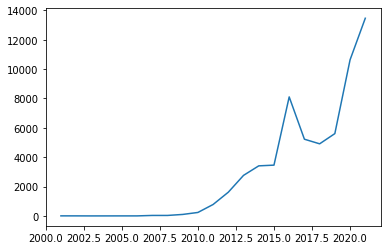

In [16]:
plt.plot(eia860_all_pv.index, eia860_all_pv['Nameplate Capacity (MW)'])
#plt.yscale('symlog')

There is no data between 1995 and 2001 so I will complete it with Heather's original PV install baseline. Also also, I believe the eia data is for utility scale only, so I will see the difference between Heather's and eia dataframes. Probably I will use Heather's since it includes residential, commercial and utility.

According to WoodMckenzie First Solar has a small percentage (~0.2 and 2%) of the commercial scale installs in 2021 and 2022. I need to check if we can share the actual values here.

Load the original PV installs data and drop the years from 2001.

In [17]:
us_installs_original = pd.read_csv(os.path.join(supportMatfolder,'output_USA_allPV_installs.csv'), index_col='Year')
us_installs_original.rename(columns={'installed_pv_MW':'Nameplate Capacity (MW)'},inplace=True)
us_installs_original_before_2001 = us_installs_original.loc[(us_installs_original.index<2001)]


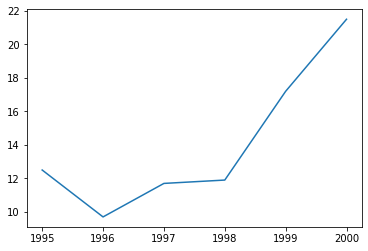

In [18]:
plt.plot(us_installs_original_before_2001.index, us_installs_original_before_2001['Nameplate Capacity (MW)'])


Now I concatenate both datasets, and boom... we get a new PV all tech installs line.

In [19]:
new_pv_installs = pd.concat([us_installs_original_before_2001, eia860_all_pv])

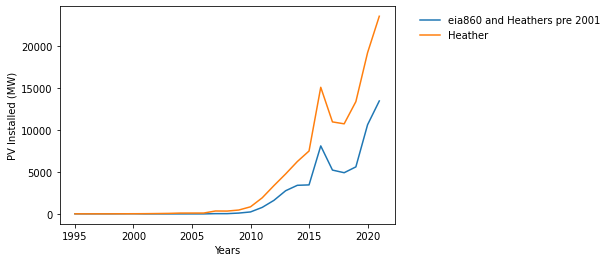

In [20]:
plt.plot(new_pv_installs.index, new_pv_installs['Nameplate Capacity (MW)'], label= 'eia860 and Heathers pre 2001')
plt.plot(us_installs_original.index, us_installs_original['Nameplate Capacity (MW)'], label= 'Heather')
plt.ylabel('PV Installed (MW)')
plt.xlabel('Years')
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')

Yes, the drop is huge. Therefore I will use the total PV installs from Heather to calculate the market shares since it represents more the total PV, not only utility.

In [21]:
us_installs_original['Nameplate Capacity (MW)'][2021]

23565.0

In [22]:
# Export to csv
new_pv_installs['Nameplate Capacity (MW)'].to_csv(os.path.join(supportMatfolder, 'output_eia860_all_pv.csv'))

---
## PV separated by tech installs and market share only for utility

Find cSi data and CdTe from the eia890 dataframe.

In [23]:
eia860_raw_cSi = eia860_raw_correct_1[eia860_raw_correct_1['Crystalline Silicon?'] == 'Y']
eia860_raw_CdTe = eia860_raw_correct_1[eia860_raw_correct_1['Thin-Film (CdTe)?'] == 'Y']
# eia860_raw_CIGS = eia860_raw[eia860_raw['Thin-Film (CIGS)?'] == 'Y']
# eia860_raw_ASi = eia860_raw[eia860_raw['Thin-Film (A-Si)?'] == 'Y']
# eia860_raw_Other = eia860_raw[eia860_raw['Thin-Film (Other)?'] == 'Y'] # Ignore 'other' because they are mixed with c-Si and it is not clear what it is

Group by year.

In [24]:
eia860_cSi = eia860_raw_cSi.groupby('Operating Year').sum()
eia860_CdTe = eia860_raw_CdTe.groupby('Operating Year').sum()
# eia860_CIGS = eia860_raw_CIGS.groupby('Operating Year').sum()
# eia860_ASi = eia860_raw_ASi.groupby('Operating Year').sum()
#eia860_Other = eia860_raw_Other.groupby('Operating Year').sum()


Concatenate cSi data pre-2001 since it was 100% c-Si.

In [25]:
eia860_cSi = pd.concat([us_installs_original_before_2001, eia860_cSi])


In [26]:
eia860_cSi.to_csv(os.path.join(supportMatfolder, 'output_eia860_c-Si_installs_utility.csv'))
eia860_CdTe.to_csv(os.path.join(supportMatfolder, 'output_eia860_CdTe_installs_utility.csv'))

Plot.

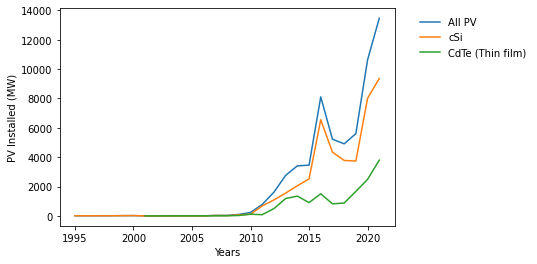

In [27]:
plt.plot(new_pv_installs.index, new_pv_installs['Nameplate Capacity (MW)'], label='All PV')
plt.plot(eia860_cSi.index, eia860_cSi['Nameplate Capacity (MW)'], label='cSi')
plt.plot(eia860_CdTe.index, eia860_CdTe['Nameplate Capacity (MW)'], label='CdTe (Thin film)')
# plt.plot(eia860_CIGS.index, eia860_CIGS['Nameplate Capacity (MW)'], label='CIGS (Thin film)')
# plt.plot(eia860_ASi.index, eia860_ASi['Nameplate Capacity (MW)'], label='A-Si (Thin film)')
#plt.plot(eia860_Other.index, eia860_Other['Nameplate Capacity (MW)'], label='Other (Thin film)')

plt.ylabel('PV Installed (MW)')
plt.xlabel('Years')
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.plot(df_installs_raw, marker='o')

### Market share calculations - utility

In [28]:
ms_utility = pd.DataFrame()
ms_utility['c-Si (%)'] = eia860_cSi['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
ms_utility['CdTe (%)'] = eia860_CdTe['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
# ms['CIGS (Thin film)'] = eia860_CIGS['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
# ms['A-Si (Thin film)'] = eia860_ASi['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
#ms['Other (Thin film)'] = eia860_Other['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
ms_utility.fillna(0, inplace=True)
ms_utility = ms_utility.round(4)
ms_utility.to_csv(os.path.join(supportMatfolder, 'output_eia860_market_share_c-Si_CdTe_utility.csv'))

Tidy data version

In [29]:
ms_utility.reset_index(inplace=True)
ms_utility = ms_utility.rename(columns={'index': 'Year'})
tidy_ms_utility = ms_utility.melt('Year', var_name='Technology', value_name='Market share')
tidy_ms_utility.to_csv(os.path.join(supportMatfolder, 'output_eia860_tidy_cSi_CdTe_market_share_utility.csv'))

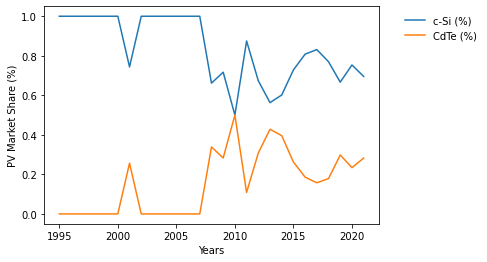

In [30]:
ax = sns.lineplot(x='Year', y='Market share', data=tidy_ms_utility, hue='Technology')
#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x))) # Sets year x axis as 
#ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.ylabel('PV Market Share (%)')
plt.xlabel('Years')
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.plot(df_installs_raw, marker='o')

## PV separated by tech installs and market share with all installs.

In this version, I use Heather's original data for all PV and c-Si fraction since it comprises residential, commercial and CdTe. CdTe is virtually only utility scale.

In [31]:
heather_csi_data = pd.read_csv(os.path.join(supportMatfolder,'output_USA_SiPV_installs.csv'), index_col='Year')
heather_csi_data.rename(columns={'0': 'Nameplate Capacity (MW)'}, inplace=True)

Since the addition of cSi and CdTe market share is a bit off, I am double check with the data from LBNL :)

In [32]:
lbnl = pd.read_excel(os.path.join(supportMatfolder,'lbnl_thinfilm.xlsx'),index_col=0)

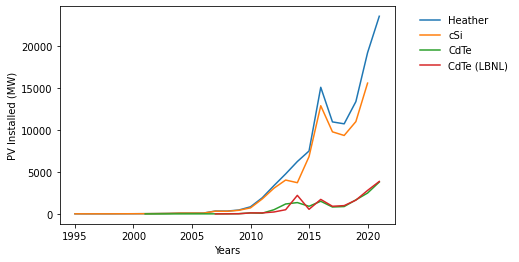

In [33]:
plt.plot(us_installs_original.index, us_installs_original['Nameplate Capacity (MW)'], label= 'Heather')
plt.plot(heather_csi_data.index, heather_csi_data['Nameplate Capacity (MW)'], label='cSi')
plt.plot(eia860_CdTe.index, eia860_CdTe['Nameplate Capacity (MW)'], label='CdTe')
plt.plot(lbnl.index, lbnl['Total (MW)'], label='CdTe (LBNL)')
plt.ylabel('PV Installed (MW)')
plt.xlabel('Years')
#plt.yscale('symlog') # Comment this one if you want to see it at normal scale
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.plot(df_installs_raw, marker='o')


Let's see the area under the curve for CdTe eiea data and for LBNL data.

In [34]:
eia860_CdTe_cut = eia860_CdTe.loc[2011:2021]['Nameplate Capacity (MW)']
lbnl_cut = lbnl.loc[2011:2021]['Total (MW)']

In [35]:
area_eia = trapz(eia860_CdTe_cut, dx=5)
area_lbnl = trapz(lbnl_cut, dx=5)
print(" area eia =", area_eia, '\n', "area lbnl =", area_lbnl)

 area eia = 66276.0 
 area lbnl = 67775.0


This one shows a more realistic scenario. Let's now calculate market share.

In [36]:
ms_all = pd.DataFrame()
ms_all['cSi'] = heather_csi_data['Nameplate Capacity (MW)']/us_installs_original['Nameplate Capacity (MW)']
ms_all['CdTe'] = eia860_CdTe['Nameplate Capacity (MW)']/us_installs_original['Nameplate Capacity (MW)']
ms_all['CdTe LBNL'] = lbnl['Total (MW)']/us_installs_original['Nameplate Capacity (MW)']

# ms['CIGS (Thin film)'] = eia860_CIGS['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
# ms['A-Si (Thin film)'] = eia860_ASi['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
#ms['Other (Thin film)'] = eia860_Other['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
ms_all.fillna(0, inplace=True)
ms_all = ms_all.round(2)
ms_all.to_csv(os.path.join(supportMatfolder, 'output_eia860_market_share_c-Si_CdTe_all.csv'))

In [37]:
ms_all['add cSi + CdTe'] = ms_all['cSi'] + ms_all['CdTe']
ms_all['add cSi + CdTe LBNL'] = ms_all['cSi'] + ms_all['CdTe LBNL']

#### Add projected market share for cSi and CdTe
I will be using 16% for CdTe and 84% for cSi

In [38]:
ms_all

,cSi,CdTe,CdTe LBNL,add cSi + CdTe,add cSi + CdTe LBNL
Year,,,,,
1995,1.00,0.00,0.00,1.00,1.00
1996,1.00,0.00,0.00,1.00,1.00
1997,0.99,0.00,0.00,0.99,0.99
1998,0.99,0.00,0.00,0.99,0.99
1999,0.98,0.00,0.00,0.98,0.98
2000,0.97,0.00,0.00,0.97,0.97
2001,0.96,0.03,0.00,0.99,0.96
2002,0.96,0.00,0.00,0.96,0.96
2003,0.95,0.00,0.00,0.95,0.95


In [39]:
ms_all['cSi'][26:56] = 0.84

In [40]:
ms_all['CdTe LBNL'][27:56] = 0.16

In [41]:
ms_all

,cSi,CdTe,CdTe LBNL,add cSi + CdTe,add cSi + CdTe LBNL
Year,,,,,
1995,1.00,0.00,0.00,1.00,1.00
1996,1.00,0.00,0.00,1.00,1.00
1997,0.99,0.00,0.00,0.99,0.99
1998,0.99,0.00,0.00,0.99,0.99
1999,0.98,0.00,0.00,0.98,0.98
2000,0.97,0.00,0.00,0.97,0.97
2001,0.96,0.03,0.00,0.99,0.96
2002,0.96,0.00,0.00,0.96,0.96
2003,0.95,0.00,0.00,0.95,0.95


### Decision to use eia or LBNL data

#### eia assumptions and data sources
* The survey Form EIA-860 collects generator-level specific information about existing and planned generators and associated environmental equipment at electric power plants with 1 megawatt or greater of combined nameplate capacity.

* The total generator nameplate capacity is the sum of the maximum ratings in MW on the nameplates of all applicable generators at a specific site. For photovoltaic solar, the total generator nameplate capacity is the sum of the AC ratings of the array.

* Data comes from individuals that submitted it to eia. I have seen some inconsistencies (as seen in the correction sections), so my level of trust has declined a bit. 

#### LBNL assumptions and data sources
* Analysis of empirical plant-level data from the U.S. fleet of ground-mounted photovoltaic (PV), PV+battery, and concentrating solar-thermal power (CSP) plants with capacities exceeding 5 MWAC. While focused on key developments in 2021, this report explores trends in deployment, technology, capital and operating costs, capacity factors, the levelized cost of solar energy (LCOE), power purchase agreement (PPA) prices, and wholesale market value.

* Theis disclaimer: While this document is believed to contain correct information, neither the United States Government nor any agency thereof, nor The Regents of the University of California, nor any of their employees, makes any warranty, express or implied, or assumes any legal responsibility for the accuracy, completeness, or usefulness of any information, apparatus, product, or process disclosed, or represents that its use would not infringe privately owned rights.

* Sources: Wood Mackenzie/SEIA Solar Market Insight Reports, Berkeley Lab.

#### My veredict:

Both sources seem reliable. **However**, LBNL seems to have data that passed some filters through Wood Mackenzie, whereas eia's seems more raw data. This have its tradeoffs, where LBNL could be a bit "diluted" so some data might be missing or omitted, on the other hand, eia has proven to have some inconsistencies where some capacity is double counted. In light of this, I decide to use LBNL because: (1) it has already been filtered, and (2) the addition with cSi does not surpass our total install capacity values.

In [42]:
ms_all.reset_index(inplace=True)
ms_all = ms_all.rename(columns={'index': 'Year'})
tidy_ms_all = ms_all.melt('Year', var_name='Technology', value_name='Market share')
tidy_ms_all.to_csv(os.path.join(supportMatfolder, 'output_eia860_tidy_cSi_CdTe_market_share_all.csv'))

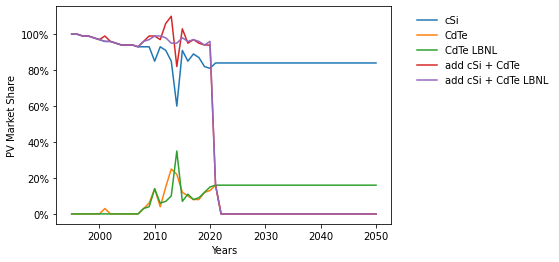

In [43]:
ax = sns.lineplot(x='Year', y='Market share', data=tidy_ms_all, hue='Technology')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x))) # Sets year x axis as 
ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.ylabel('PV Market Share')
plt.xlabel('Years')
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.plot(df_installs_raw, marker='o')

## PV installs projection for final cSi and CdTe installs (not finished)

Here I base the projections on the Electrification Futures scenario.

Upload Electrification Futures baseline.

In [44]:
sf_reeds_alts = pd.read_excel(os.path.join(supportMatfolder,'SF_reeds_alternates.xlsx'),index_col=0)
sf_reeds = sf_reeds_alts.loc[2022:2050,['MW']]
sf_reeds.loc[2022, ['MW']] = 15000

In [45]:
sf_reeds

,MW
year,
2022.0,15000.00000
2023.0,24236.41597
2024.0,24236.41597
2025.0,74146.08849
2026.0,74146.08849
2027.0,57401.30156
2028.0,57401.30156
2029.0,81197.98651
2030.0,81197.98651


#### Reorder the installed capacity. 
Refer to Heather for explanation why. In a nutshell: The Reeds projections have massive drops in capacity in certain years, this is challenging because such drops would significantly affect the solar industry.

In [46]:
sf_reeds.index = sf_reeds.index.astype(int)

In [47]:
sf_reeds

,MW
year,
2022,15000.00000
2023,24236.41597
2024,24236.41597
2025,74146.08849
2026,74146.08849
2027,57401.30156
2028,57401.30156
2029,81197.98651
2030,81197.98651


In [48]:
sf_reeds['MW'].values.sort()
sf_reeds.rename(columns={'MW':'Nameplate Capacity (MW)'},inplace=True)

#### Concatenate values withe ore 2023 values and add projected market share

In [49]:
us_installs_original_snip = pd.DataFrame(us_installs_original.loc[1995:2021, 'Nameplate Capacity (MW)'])

In [50]:
full_installs = pd.DataFrame()

In [51]:
full_installs = pd.concat([us_installs_original_snip, sf_reeds], axis=0)

In [52]:
full_installs

,Nameplate Capacity (MW)
1995,12.50000
1996,9.70000
1997,11.70000
1998,11.90000
1999,17.20000
2000,21.50000
2001,29.00000
2002,44.40000
2003,63.00000
2004,100.80000


Add the value for 2022:

In [53]:
ms_all = ms_all.set_index('Year')

In [54]:
full_installs['cSi Market Share'] = ms_all['cSi']
full_installs['CdTe Market Share'] = ms_all['CdTe LBNL']

In [55]:
full_installs['cSi Capacity (MW)'] = full_installs['Nameplate Capacity (MW)']*full_installs['cSi Market Share']
full_installs['CdTe Capacity (MW)'] = full_installs['Nameplate Capacity (MW)']*full_installs['CdTe Market Share']

In [56]:
full_installs.to_csv(os.path.join(supportMatfolder, 'output_RELOG_cSi_CdTe_capacity_reeds.csv'))

In [57]:
len(full_installs)

56

In [58]:
full_installs

,Nameplate Capacity (MW),cSi Market Share,CdTe Market Share,cSi Capacity (MW),CdTe Capacity (MW)
1995,12.50000,1.00,0.00,12.500000,0.000000
1996,9.70000,1.00,0.00,9.700000,0.000000
1997,11.70000,0.99,0.00,11.583000,0.000000
1998,11.90000,0.99,0.00,11.781000,0.000000
1999,17.20000,0.98,0.00,16.856000,0.000000
2000,21.50000,0.97,0.00,20.855000,0.000000
2001,29.00000,0.96,0.00,27.840000,0.000000
2002,44.40000,0.96,0.00,42.624000,0.000000
2003,63.00000,0.95,0.00,59.850000,0.000000
2004,100.80000,0.94,0.00,94.752000,0.000000


---
## Appendix: Market share correction

That moment in 2001 indicates that there is something odd in the eia data. Going back to the original excel, I can see that some values are marked as both, c-Si and CdTe so I am accidentally double counting. I found these conflicting years, and what I will do is to find the real values and also source them from Heather's original PV baselines.

Now let's look at the conflicting years that share CdTe and PV.

In [ ]:
eia860_raw[(eia860_raw['Crystalline Silicon?'] == 'Y') & (eia860_raw['Thin-Film (CdTe)?'] == 'Y')][['Operating Year', 'Nameplate Capacity (MW)', 'Plant Name', 'Crystalline Silicon?', 'Thin-Film (CdTe)?']]

There are also repeated c-Si with CIGS, A-Si and 'other materials'. I am going to ignore these since their contribution to the overall capacity is almost neglectable.

Doing some research, it appears that the 2001 plant Springerville had indeed both, CdTe and c-Si. From [this paper](https://www.sciencedirect.com/science/article/pii/S1473832503010046): 3.5 MW DC of crystalline silicon and thin-film modules. The Springerville site has over 1 MW of thin-film. It is a lower number than the eia. According to this, I split that 3.7 MW and assume 2.7 MW of c-Si and 1 MW of CdTe.

Solar Gen 2 Solar Facility is [solely CdTe](https://www.southernpowercompany.com/content/dam/southernpower/pdfs/fact-sheets/SolarGEN2_Solar_Facility_factsheet.pdf) with 163 MW of more than 1 million First Solar modules. I don't know why they split it in three (54.4 x 3 = 163.2), this checks out so I will jsut convert these three into a three that are only CdTe (i.e. I change Silicon to 'N'). Luckily Solar Gen 2 has the data only in 2014. This should be easy to fix :).

Lastly, I have not able to find anything about Springbok 3 Solar Farm Hybrid. If it was using CdTe probably First Solar would have announced it in one of their reports. Therefore I am going to assume that that 90 MW is solely c-Si.